# Locally Linear Embedding (LLE)

##### 패키지 불러오기

In [65]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from multiprocessing import Pool
import time
import matplotlib.patheffects as PathEffects
from scipy.spatial import distance_matrix
import seaborn as sns
from matplotlib.pyplot import style
from sklearn.manifold import LocallyLinearEmbedding

import warnings
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra
warnings.filterwarnings('ignore')


random.seed(9697)
np.random.seed(9697)

##### MNIST 데이터셋 불러오기
##### 전체 데이터셋 중 1/30만 사용했음

In [66]:
mnist = fetch_openml('mnist_784')
df = mnist.data
df['target'] =mnist.target 
data = mnist.data[::30]
target = mnist.target[::30]

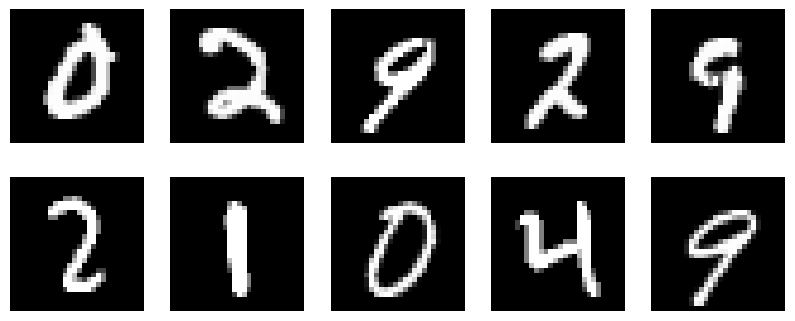

In [67]:
# 0~69999 숫자 중 랜덤으로 10개 선별(인덱스 기준)
random_idx = np.random.choice(70000, 10)

# 흰색 배경 및 크기 지정
style.use('default')
figure = plt.figure()
figure.set_size_inches(10, 4)

# 시각화를 위한 target column 제외
columns_list = list(df.columns)
columns_list.remove('target')

# 흑백으로 출력하기 위한 스타일 설정
style.use('grayscale')

# 2 * 5 사이즈의 격자 설정
axes = []
for i in range(1, 11):
    axes.append(figure.add_subplot(2, 5, i))

num_list = []
for i in range(10):
    num = df.loc[random_idx[i], columns_list] # 랜덤으로 선별된 인덱스 위치에 해당하는 픽셀 정보 가져오기
    num = np.array(num).reshape(-1, 28).astype(int) # 픽셀값을 28 * 28 사이즈로 바꾸고 정수형 변환 진행
    num_list.append(num)

for i in range(10):
    axes[i].matshow(num_list[i]) # 10개 숫자 차례대로 시각화
    axes[i].set_axis_off() # x축, y축 눈금 제거

#### LLE step1: 모든 $x_i$에 대해서 이웃을 정의
##### embedding 차원, k-neighbors를 정의

In [4]:
def get_neighbors(x, emb_dim:int = 2, K:int = 10):
    # number of samples and data dimensions
    N, D = x.shape
    
    # get euclidean distance matrix to fine neighbors
    distance_M = distance_matrix(x,x)
    
    # get K-neigbors for each x
    indices = distance_M.argsort(axis=1)
    neighbors = indices[:,1:K+1]
    
    return neighbors

In [5]:
neighbors = get_neighbors(data, K=20)
print(f'neighbor indices matrix shape : (N, K) = {neighbors.shape}')

neighbor indices matrix shape : (N, K) = (2334, 20)


##### LLE step2: 모든 $x_i$에 대한 재구축 오차를 최소화하는 $w_{ij}$를 찾기

In [8]:
def get_W(x, emb_dim:int = 2, K:int = 10, neighbors:np.array = None):

    # number of samples and data dimensions
    N, D = x.shape
    
    # W_i shape : N,K
    W_i = np.zeros_like(neighbors, dtype=float)
    
    for i in range(N):
        x_j = x[neighbors[i,:],:] # neighbors of x_i
        
        diff = x_j - np.repeat(np.expand_dims(x[0,:],0), K, axis=0) # x_i - x_j for all j
        mse = np.dot(diff, np.transpose(diff))
        mse = mse+np.identity(K) + 1e-3*np.trace(mse)
        W_i[i,:] = np.linalg.solve(mse, np.ones((K,1)))[:,0] # get w_ij
        W_i[i,:] = W_i[i,:] / np.sum(W_i[i,:]) # constraints sum of w_j = 1
    
    # W shape : N,N
    W = np.zeros(shape=(N,N), dtype=float)
    
    for i in range(N):
        j_indices = neighbors[i]
        for k,j in enumerate(j_indices):
            W[i,j] = W_i[i,k]
    
    return W
W = get_W(data.values, K=20, neighbors=neighbors)
print(f'W matrix shape : (N, N) = {W.shape}')

W matrix shape : (N, N) = (2334, 2334)


##### LLE step3: 모든 $y_i$에 대해서 $|y_i - \Sigma_{j=1}^Kw_{ij}*y_j|^2 = y^TMy$를 최소화하는 $y_i$찾기

In [10]:
def get_y(x, emb_dim:int = 2, K:int = 10, neighbors:np.array = None, W:np.array = None):
    N, D = x.shape
    
    I = np.identity(N, dtype=float) # I shape : (N,N)
    M = np.matmul(np.transpose(I-W),(I-W)) # M shape : (N,N)

    ei_vals, ei_vec = np.linalg.eig(M)
    indices = np.argsort(ei_vals)
    emb_idx = indices[1:emb_dim+1]
    
    y = ei_vec[:,emb_idx]*np.sqrt(N)
    
    return y
y = get_y(data, K=20, neighbors=neighbors, W=W)

##### LLE step을 통해서 시각화하기

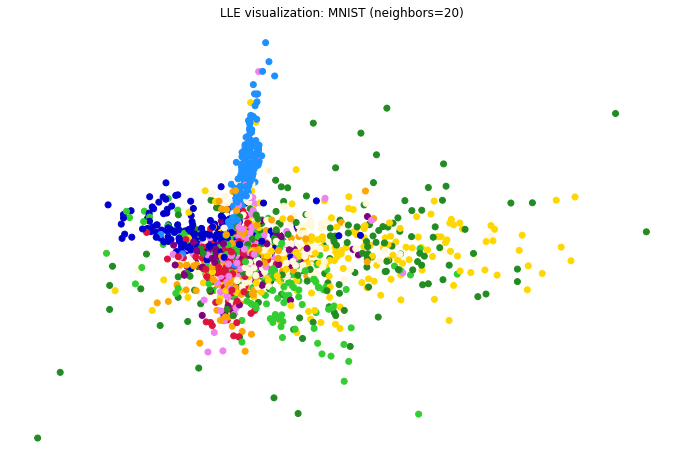

In [60]:
scaffold_colors = ['purple', 'crimson', 'forestgreen', 'mediumblue', 'orange',
                   'limegreen', 'violet', 'dodgerblue', 'gold', 'cornsilk']
plt.figure(figsize=(12, 8))
colors = [scaffold_colors[idx] for idx in pd.factorize(target)[0]]
plt.scatter(y[:, 0], y[:, 1], c = colors)
plt.title("LLE visualization: MNIST (neighbors=20)")
plt.axis('off')
plt.show()

##### sklearn 패키지를 사용했을때와 비교

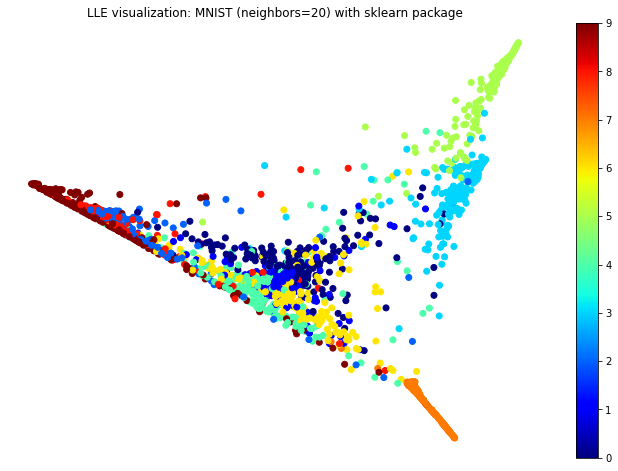

In [61]:
X_lle = LocallyLinearEmbedding(n_components=2, random_state=9697).fit_transform(data)

plt.figure(figsize=(12, 8))
plt.scatter(X_lle[:,0], X_lle[:,1], c = pd.factorize(target)[0], cmap='jet')
plt.colorbar()
plt.title("LLE visualization: MNIST (neighbors=20) with sklearn package")
plt.axis('off')
plt.show()

#### Sklearn 패키지와 비교를 해보았을 때 차이가 많이 나는 것을 보아 LLE step에서 오류가 있는 것 같음